In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from PIL import Image
import random
from scipy.ndimage import sobel

Upload files.

In [4]:
from google.colab import files
uploaded = files.upload() #we need train and test data, possibly model itself

Saving flatland.pth to flatland.pth


In [5]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


Data augmentation/making data usable. Here we apply padding, sobel filter and some flips in order to make data easier to learn from and to increase dataset size. At the same time we prepare data for model evaluation.

In [6]:
import pickle, gzip
X, y = pickle.load(gzip.open("flatland_train.data", 'rb'))
X_eval, _ = pickle.load(gzip.open("flatland_test.data", 'rb'))

In [7]:
y = np.where(y != 0, y - 2, y)  # Convert labels to 0, 1, 2, 3
X = torch.tensor(X, dtype=torch.float32) / 255.0  # Normalize pixel values
X_eval = torch.tensor(X_eval, dtype=torch.float32) / 255.0
y = torch.tensor(y, dtype=torch.long)

In [8]:
def apply_padding(X, pad_size=1):
    # Adding zero padding around the images
    X_padded = F.pad(X, (pad_size, pad_size, pad_size, pad_size), mode='constant', value=0)
    return X_padded

# Function to apply Sobel filter
def apply_sobel(X):
    X_sobel = np.zeros_like(X)  # Placeholder for the Sobel filtered images
    for i in range(X.shape[0]):  # Loop through each image in the batch
        img = X[i].numpy()  # Convert to NumPy array
        sobel_x = sobel(img, axis=1)  # Sobel filter in x-direction
        sobel_y = sobel(img, axis=0)  # Sobel filter in y-direction
        sobel_img = np.hypot(sobel_x, sobel_y)  # Magnitude of gradient, spalva keiciasi
        X_sobel[i] = torch.tensor(sobel_img)  # Convert back to torch tensor
    return torch.tensor(X_sobel, dtype=torch.float32)


# Apply padding to the dataset
X = apply_padding(X, pad_size=1)

# Apply Sobel filter to the padded dataset
X = apply_sobel(X)

# If you want to apply padding to the eval data as well
X_eval = apply_padding(X_eval, pad_size=1)
X_eval = apply_sobel(X_eval)

X = torch.tensor(X, dtype=torch.float32)
X_eval = torch.tensor(X_eval, dtype=torch.float32)

<ipython-input-8-dc1b61e1ddb9>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-8-dc1b61e1ddb9>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_eval = torch.tensor(X_eval, dtype=torch.float32)


In [9]:
X_vertical_flip = torch.flip(X, dims=[2])
X_horizontal_flip = torch.flip(X, dims=[1])
X_diagonl_flip = torch.flip(X_horizontal_flip, dims=[2])

X = torch.cat((X, X_vertical_flip, X_horizontal_flip, X_diagonl_flip), dim=0)

y_tensor = torch.tensor(y) if isinstance(y, np.ndarray) else y
y = torch.cat((y_tensor, y_tensor, y_tensor, y_tensor), dim=0)

Example of how our changed data looks like.

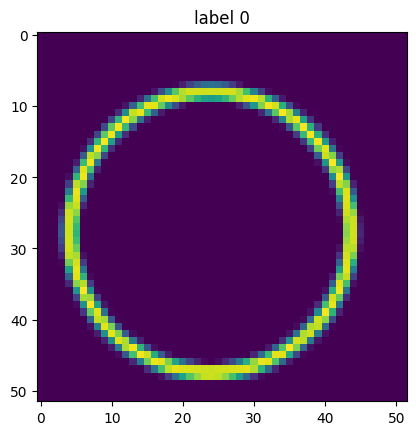

In [52]:
plt.imshow(X[16])
plt.title(f"label {y[16]}")
plt.show()

Train/test split.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

train_dataset_ = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset_, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Our CNN model.

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer with kernel size 2x2

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)

        # Dropout layers
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Convolutional layers with ReLU activation and BatchNorm
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 6 * 6)

        # Fully connected layers with ReLU and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

Model initialization.

In [13]:
model = CNN().to(device)
model.load_state_dict(torch.load("flatland.pth", map_location=torch.device('cpu')))
criterion = nn.CrossEntropyLoss() #label_smoothing = 0.1
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

<ipython-input-13-7808a5cdcd1b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("flatland.pth", map_location=torch.device('cpu')))


Training model code that also gives some statistics along the way.

In [15]:
num_epochs = 1  # Adjust as needed

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []


for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_train_loss)
    epoch_train_acc = 100 * correct_train / total_train
    train_acc_history.append(epoch_train_acc)


    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    epoch_val_loss = val_loss / len(test_loader)
    val_loss_history.append(epoch_val_loss)
    epoch_val_acc = 100 * correct_val / total_val
    val_acc_history.append(epoch_val_acc)

    print(f"Epoch: {epoch + 1}, Train Loss: {epoch_train_loss:.3f}, Val Loss: {epoch_val_loss:.3f}")
    print(f"Train Acc: {epoch_train_acc:.2f}%, Val Acc: {epoch_val_acc:.2f}%")


Epoch: 1, Train Loss: 0.052, Val Loss: 0.168
Train Acc: 98.57%, Val Acc: 98.22%


Create dataset of evaluation data and evalute model.

In [16]:
X_eval.shape

torch.Size([10000, 52, 52])

In [17]:
X_eval = X_eval.unsqueeze(1)

In [18]:
eval_loader = torch.utils.data.DataLoader(X_eval, batch_size=512, shuffle=False)

In [19]:
model.eval()  # Set the model to evaluation mode

predictions = []

with torch.no_grad():  # No need to calculate gradients for evaluation
    for images in eval_loader:
        images = images.to(device)
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get the index of the max logit (predicted class)
        predictions.extend(predicted.cpu().numpy())


predictions = np.array(predictions)

predictions = np.where(predictions != 0, predictions + 2, predictions)
predictions[0:7]

array([6, 6, 4, 5, 5, 3, 3])

If needed save the predictions and the model itself.

In [65]:
with open('preds.txt', 'w') as f:
    for pred in predictions:
        f.write(str(pred))

In [66]:
# Save the model
torch.save(model.state_dict(), "flatland.pth")
from google.colab import files  # For Google Colab
files.download("flatland.pth")
# To load the model later
# model = CNN()
# model.load_state_dict(torch.load("cnn_flatland.pth"))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>